## Resampling and the Bootstrap

Welcome to lab 7!

The British Royal Air Force wanted to know how many warplanes the Germans had (some number `N`, a *population parameter*), and they needed to estimate that quantity knowing only a random sample of the planes' serial numbers (from 1 to `N`). We know that the German's warplanes are labeled consecutively from 1 to `N`, so `N` would be the total number of warplanes they have. 

We used to investigate the random variation in estimates by simulating sampling from the population many times and computing estimates from each sample.  In real life, if the RAF had known what the population looked like, they would have known `N` and would not have had any reason to think about random sampling.  They didn't know what the population looked like, so they couldn't have run the simulations we did.  So that was useful as an exercise in *understanding random variation* in an estimate, but not as a tool for practical data analysis.

Now we'll flip that idea on its head to make it practical.  Given *just* a random sample of serial numbers, we'll estimate `N`, and then we'll use simulation to find out how accurate our estimate probably is, without ever looking at the whole population.  This is an example of *statistical inference*.

As usual, **run the cell below** to prepare the lab and the automatic tests.

In [1]:
# Run this cell to set up the notebook, but please don't change it.
! pip install -U okpy

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# These lines load the tests.
from client.api.notebook import Notebook
ok = Notebook('lab07.ok')
_ = ok.auth(inline=True)

Requirement already up-to-date: okpy in /usr/local/anaconda3/lib/python3.6/site-packages (1.13.11)
Requirement not upgraded as not directly required: requests==2.12.4 in /usr/local/anaconda3/lib/python3.6/site-packages (from okpy) (2.12.4)
Requirement not upgraded as not directly required: coverage==3.7.1 in /usr/local/anaconda3/lib/python3.6/site-packages (from okpy) (3.7.1)
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Assignment: Resampling and the Bootstrap
OK, version v1.13.11



ERROR  | auth.py:91 | {'error': 'invalid_grant'}



Open the following URL:

https://okpy.org/client/login/

After logging in, copy the code from the web page and paste it into the box.
Then press the "Enter" key on your keyboard.

Paste your code here: 


ERROR  | auth.py:91 | {'error': 'invalid_grant'}


---------------------------------------------------------------------
Authentication error: invalid grant
---------------------------------------------------------------------


## 1. Preliminaries
The setup: We (the RAF in World War II) want to know the number of warplanes fielded by the Germans.  That number is `N`.  The warplanes have serial numbers from 1 to `N`, so `N` is also equal to the largest serial number on any of the warplanes.

We only see a small number of serial numbers (assumed to be a random sample with replacement from among all the serial numbers), so we have to use estimation.

#### Question 1.1
Is `N` a population parameter or a statistic?  If we compute a number using our random sample that's an estimate of `N`, is that a population parameter or a statistic?

*Write your answer here, replacing this text.*

To make the situation realistic, we're going to hide the true number of warplanes from you.  You'll have access only to this random sample:

In [2]:
observations = Table.read_table("serial_numbers.csv")
num_observations = observations.num_rows
observations

serial number
47
42
57
79
26
23
36
64
83
135


#### Question 1.2
Define a function named `plot_serial_numbers` to make a histogram of any table of serial numbers.  It should take one argument, a table like `observations` with one column called `"serial number"`.  It should plot a histogram of the values in the column **using bins of width 1** ranging from **1 to 200** but return nothing.  Then, call that function to make a histogram of `observations`.

In [ ]:
def plot_serial_numbers(numbers):
    ...
    
    # Assuming the lines above produce a histogram, this next
    # line may make your histograms look nicer.  Feel free to
    # delete it if you want.
    plt.ylim(0, .25)

plot_serial_numbers(observations)

#### Question 1.3
By looking at the histogram, what can we say about `N` immediately? (Hint: What is the relationship between `N` and the largest serial number in `observations`?) What does each little bar in the histogram represent and why are all the bars the same height?

*Write your answer here, replacing this text.*

#### Question 1.4
One way to estimate `N` was to take twice the mean of the serial numbers we see. Write a function that computes that statistic.  It should take as its argument an array of serial numbers and return twice their mean.  Call it `mean_based_estimator`.  

Use it to compute an estimate of `N` called `mean_based_estimate`.

In [6]:
def mean_based_estimator(nums):
    ...

mean_based_estimate = ...
mean_based_estimate

Ellipsis

In [7]:
_ = ok.grade('q1_4')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q1_4 > Suite 1 > Case 1

>>> import numpy as np
>>> # It looks like you forgot to return something.
>>> mean_based_estimator(np.array([1, 2, 3])) is not None
False

# Error: expected
#     True
# but got
#     False

Run only this test case with "python3 ok -q q1_4 --suite 1 --case 1"
---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab07.ipynb'.
Backup... 0.0% complete
Could not backup: Assignment does not exist



#### Question 1.5
We also estimated `N` using the biggest serial number in the sample.  Compute it, giving it the name `max_estimate`.

In [8]:
max_estimate = ...
max_estimate

Ellipsis

In [9]:
_ = ok.grade('q1_5')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q1_5 > Suite 1 > Case 1

>>> max_estimate
Ellipsis

# Error: expected
#     135
# but got
#     Ellipsis

Run only this test case with "python3 ok -q q1_5 --suite 1 --case 1"
---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab07.ipynb'.
Backup... 0.0% complete
Could not backup: Assignment does not exist



## 2. Resampling
To do get a sense of the accuracy of our estimates, we'll use resampling.  That is, we won't exactly simulate the observations the RAF would have really seen.  Rather we sample from our current sample, or "resample."

Why does that make any sense?

When we tried to estimate `N`, we would have liked to use the whole population.  Since we had only a sample, we used that to estimate `N` instead.

This time, we would like to use the population of serial numbers to *run a simulation* about estimates of `N`.  But we still only have our sample.  We use our sample in place of the population to run the simulation.

So there is a simple analogy between estimating `N` and simulating the variability of estimates.

$$\text{computing }N\text{ from the population}$$
$$:$$
$$\text{computing an estimate of }N\text{ from a sample}$$

$$\text{as}$$

$$\text{simulating the distribution of estimates of }N\text{ using samples from the population}$$
$$:$$
$$\text{simulating an (approximate) distribution of estimates of }N\text{ using resamples from a sample}$$

#### Question 2.1
Write a function called `simulate_resample`.  It should generate a resample from the observed serial numbers in `observations` and return that resample.  (The resample should be a table like `observations`.)  It should take no arguments.

In [10]:
def simulate_resample():
    ...

Let's make one resample.

In [11]:
# This is a little magic to make sure that you see the same results
# we did.
np.random.seed(123)

one_resample = simulate_resample()
one_resample

In [12]:
_ = ok.grade('q2_1')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q2_1 > Suite 1 > Case 1

>>> one_resample.num_rows
AttributeError: 'NoneType' object has no attribute 'num_rows'

# Error: expected
#     17
# but got
#     Traceback (most recent call last):
#       ...
#     AttributeError: 'NoneType' object has no attribute 'num_rows'

Run only this test case with "python3 ok -q q2_1 --suite 1 --case 1"
---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab07.ipynb'.
Backup... 0.0% complete
Could not backup: Assignment does not exist



Later, we'll use many resamples at once to see what estimates typically look like.  We don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's examine some individual resamples before we start using them.

#### Question 2.2
Make a histogram of your resample using the plotting function you defined earlier in this lab, **and** a separate histogram of the original observations.

In [13]:
...
...

Ellipsis

#### Question 2.3
Which of the following are true:
1. In the plot of the resample, there are no bars at locations that weren't there in the plot of the original observations.
2. In the plot of the original observations, there are no bars at locations that weren't there in the plot of the resample.
3. The resample has exactly one copy of each serial number.
4. The sample has exactly one copy of each serial number.

Assign true_statements to a list of the correct statements.

In [14]:
true_statements = ...

In [15]:
_ = ok.grade('q2_3')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q2_3 > Suite 1 > Case 1

>>> true_statements
Ellipsis

# Error: expected
#     [1, 4]
# but got
#     Ellipsis

Run only this test case with "python3 ok -q q2_3 --suite 1 --case 1"
---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab07.ipynb'.
Backup... 0.0% complete
Could not backup: Assignment does not exist



#### Question 2.4
Create two more resamples using the function `simulate_resample` from above. For each resampled data, plot it and compute its max- and mean-based estimates.

In [16]:
resample_0 = ...
...
mean_based_estimate_0 = ...
max_based_estimate_0 = ...
print("Mean-based estimate for resample 0:", mean_based_estimate_0)
print("Max-based estimate for resample 0:", max_based_estimate_0)

resample_1 = ...
...
mean_based_estimate_1 = ...
max_based_estimate_1 = ...
print("Mean-based estimate for resample 1:", mean_based_estimate_1)
print("Max-based estimate for resample 1:", max_based_estimate_1)

Mean-based estimate for resample 0: Ellipsis
Max-based estimate for resample 0: Ellipsis
Mean-based estimate for resample 1: Ellipsis
Max-based estimate for resample 1: Ellipsis


## 3. OPTIONAL Simulating with resampling
Since resampling from a sample looks just like sampling from a population, the code should look almost the same.  That means we can write a function that simulates either sampling from a population or resampling from a sample.  If we pass it a population as its argument, it will do the former; if we pass it a sample, it will do the latter.

#### Question 3.1
Write a function called `simulate_estimates`.  It should take 4 arguments:
1. A table from which the data should be sampled.  The table will have 1 column named `"serial number"`.
2. The size of each sample from that table, an integer.  (For example, to do resampling, we would pass for this argument the number of rows in the table.)
3. A function that computes a statistic of a sample.  This argument is a *function* that takes an array of serial numbers as its argument and returns a number.
4. The number of replications to perform.

It should simulate many samples with replacement from the given table.  (The number of samples is the 4th argument.)  For each of those samples, it should compute the statistic on that sample. Then it should return an array containing each of those statistics.  The code below provides an example use of your function and describes how you can verify that you've written it correctly.

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

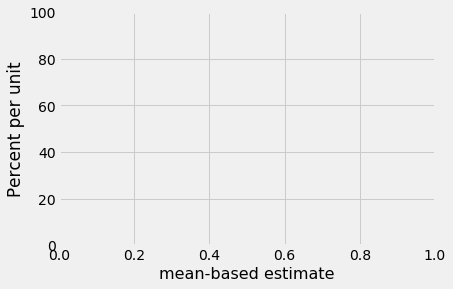

In [17]:
def simulate_estimates(original_table, sample_size, statistic, num_replications):
    # Our implementation of this function took 5 short lines of code.
    ...

# This should generate an empirical histogram of twice-mean estimates
# of N from samples of size 50 if N is 1000.  This should be a bell-shaped
# curve centered at 1000 with most of its mass in [800, 1200].  To verify your
# answer, make sure that's what you see!
example_estimates = simulate_estimates(
    Table().with_column("serial number", np.arange(1, 1000+1)),
    50,
    mean_based_estimator,
    10000)
Table().with_column("mean-based estimate", example_estimates).hist(bins=np.arange(0, 1500, 25))

Now we can go back to the sample we actually observed (the table `observations`) and estimate how much our mean-based estimate of `N` would have varied from sample to sample.

#### Question 3.2
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *mean-based estimates* of `N`.  Use 5,000 replications.  
We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

TypeError: unsupported operand type(s) for +: 'ellipsis' and 'float'

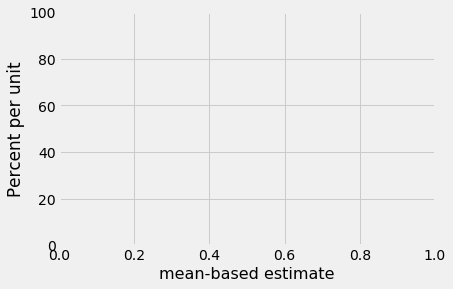

In [18]:
bootstrap_estimates = ...
Table().with_column("mean-based estimate", bootstrap_estimates).hist(bins=np.arange(0, 200, 4)) 

In [27]:
# For your convenience, you can run this cell to run all the tests at once!
import os
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q2_3 > Suite 1 > Case 1

>>> true_statements
Ellipsis

# Error: expected
#     [1, 4]
# but got
#     Ellipsis

Run only this test case with "python3 ok -q q2_3 --suite 1 --case 1"
---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q1_5 > Suite 1 > Case 1

>>> max_estimate
Ellipsis

# Error: expected
#     135
# but got
#     Ellipsis

Run only this test case with "python3 ok -q q1_5 --suite 1 --case 1"
---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [28]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab07.ipynb'.
Submit... 0.0% complete
Could not submit: Assignment does not exist
Backup... 0.0% complete
Could not backup: Assignment does not exist

